# Which patients would get treatment based on different ways to make the decision to give treatment (notebook 1 from set of n)

### Plain English summary

Analyse the impact of 14 scenarios for deciding who gets treatment. How does this difference in decision making affect patient outcomes? Here we also explore different ways of defining the 'best outcome'.

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision (25 hospitals with highest SHAP hospital value)
1. Low-benchmark treatment decision (25 hospitals with lowest SHAP hospital value)
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

### Model and data

#### Models
This notebook uses two XGBoost models.

1) Model to predict whether get treatment 

Model: XGBoost classifier [from notebook 200]\
Target feature: Give thrombolysis\
Input features: 9 features (prior_disability, stroke_severity, stroke_team, age, onset_to_arrival_time, arrival_to_scan_time, precise_onset_known, onset_during_sleep, afib_anticoagulant)\
Kfold split: First kfold split


Note: The original thrombolysis choice model had 10 features. For this analysis, we only have ischaemic patients, and don't include anyone taking AF anticoagulants, so no need for those two related features

2) Model to predict the disability at discharge

Model: XGBoost classifier (multiclass classification) [from notebook 040]\
Target feature: Discharge disability\
Input features: 7 features (prior_disability, stroke_severity, stroke_team, age, onset_to_thrombolysis_time, any_afib_diagnosis, precise_onset_known)\
Kfold split: First kfold split

Use the model to predict each patients mRS probability distributions with/without thrombolysis (individual mRS probability, cumulative probability distributions, and weighted mRS). The scenario will determine whether the patient gets treatment. For those patients that did not get thrombolysis in the observed dataset, assume their scan-to-treatment is the median of the hospital attended.

#### Data.

Use dataset '02_reformatted_data_ml_include_mt.csv'

This analysis includes patients that are:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic strokes (filter included in input dataset '02_reformatted_data_ml_include_mt.csv')
* Can have had thrombectomy (included in input dataset '02_reformatted_data_ml_include_mt.csv')

### Aims

### Observations


#### Further work
Is benchmark just really defined by people giving thtrombolysis to the large group of people with mild strokes.

Opposing approaches for giving IVT:
Not too worreid how much benefit give, just so long as not doing harm.
Or the other way is only giving it when I see there's a clear reason to.

#### Resources
pip install plotly
pip install dash

https://github.com/timyerg/venny4py?tab=readme-ov-file
https://github.com/tctianchi/pyvenn
https://pypi.org/project/venn/

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression

from os.path import exists

import math

from matplotlib.ticker import MaxNLocator #force all mrs categories to be shown on the x axis

import time

# for venn diagram (pip install matplotlib_venn)
# https://pypi.org/project/matplotlib-venn/
from matplotlib_venn import venn3
from matplotlib_venn import venn2

# for venn diagram with 3+ sets (pip install venny4py)
from venny4py.venny4py import *

# For the 3+ sets venn diagram
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse

# for radar plot
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import copy

import json

Report the time duration to run notebook

In [2]:
start_time = time.time()

Set to use only the first kfold

In [3]:
k = 0

Select the features for the model to predict disability discharge

In [4]:
selected_features_mrs = ["prior_disability", "stroke_severity", "stroke_team", 
                         "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                         "precise_onset_known", "discharge_disability"]

Select the features for the model to predict decision to give thrombolysis

In [5]:
selected_features_treatment = ["prior_disability", "stroke_severity", 
                     "age", "arrival_to_scan_time", "precise_onset_known", 
                     "onset_to_arrival_time","onset_during_sleep", 
                     "afib_anticoagulant", "stroke_team"]

Get union of both sets of features

In [6]:
selected_features_set = list(set.union(set(selected_features_mrs), 
                                       set(selected_features_treatment)))

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [7]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    model_text: str = 'xgb_all_data_multiclass_outcome'
    notebook: str = '210_'

paths = Paths()

Create output folders if needed

In [8]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Read in the full dataset (not kfold splits). Include patients that may have had thrombectomy

In [9]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        '02_reformatted_data_ml_include_mt.csv')
data_all_features = pd.read_csv(filename)

Read in the ranked hospital list (created in notebook 200), extract the top and bottom 25 hospitals.

In [10]:
filename = os.path.join(paths.data_save_path, 
    ('200_xgb_9_features_all_data_thrombolysis_decision_ranked_hospitals_median_shap.csv'))

benchmark_hospitals = pd.read_csv(filename)
# Extract top 25 hospitals
high_benchmark_hospitals = list(benchmark_hospitals['hospital'].head(25))
# Extract bottom 25 hospitals
low_benchmark_hospitals = list(benchmark_hospitals['hospital'].tail(25))

## Filter patients
Keep only patients with onset to scan time of 4hours 15mins (so 15 mins to treat). This is 255 minutes.

In [11]:
mask = (data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]) <= 255
data_all_features = data_all_features[mask]

Store number fo patients in analysis

In [12]:
n_patients = data_all_features.shape[0]

## Store data details prior to one hot encoding

Store stroke team attended (before one hot encode it)

In [13]:
data_stroke_team = data_all_features["stroke_team"]

## Create new features

### 1. Create series "onset_to_thrombolysis_time_all_treated" for all patients.

To be used for the scenarios when patients that are not treated in the dataset are treated in the scenario (they are without a scan to treatment time, use the average for the hospital they attended)

First calculate the average scan_to_thrombolysis_time for those patients that got treated (per hospital) as then use this for those that do not get treatment.

In [14]:
# median scan to treatment for the treated patients (per hosptial)
mask_treatment = data_all_features["onset_to_thrombolysis_time"] > -100
median_scan_to_needle_time = (
    data_all_features[mask_treatment].groupby(["stroke_team"])["scan_to_thrombolysis_time"].median())

median_scan_to_needle_time.describe()

count    118.000000
mean      33.351695
std        9.763071
min       13.000000
25%       27.000000
50%       33.000000
75%       40.000000
max       75.000000
Name: scan_to_thrombolysis_time, dtype: float64

Create a new series "onset_to_thrombolysis_time_all_treated" which takes the dataset value for those patients that are treated in the dataset. For those patients that are not treated in the dataset add the median hospital scan to treatment time to their individual onset to scan times.

In [15]:
# Identify patients not recieve treatment in the dataset
mask_not_treated = data_all_features["scan_to_thrombolysis_time"] == -100

# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated = data_all_features["onset_to_thrombolysis_time"].copy(deep=True)

# For those patients not recieve treatment in the dataset, use the median scan to treatment of their attended hosptial
onset_to_scan_time = data_all_features["onset_to_arrival_time"] + data_all_features["arrival_to_scan_time"]
onset_to_thrombolysis_time_all_treated[mask_not_treated] = (
    onset_to_scan_time[mask_not_treated] + 
    median_scan_to_needle_time[data_all_features["stroke_team"]].values[mask_not_treated])

### 2. Create series "onset_to_thrombolysis_time_all_treated_30mins_d2n" for all patients.

All hospitals are able to treat patients with a 30 minute door to needle time (use patients own onset to scan times).

In [16]:
# Take a deep copy of the onset to thrombolysis time. This will remain unchanged 
# for those patients that recieve treatment in the dataset
onset_to_thrombolysis_time_all_treated_30mins_d2n = (
                    data_all_features["onset_to_arrival_time"] + 30)

### 3. Create series "onset_to_thrombolysis_time_all_treated_within_30mins_d2n" for all patients.

All hospitals are able to treat patients within a 30 minute door to needle time (use patients own door to needle time if < 30 minutes).

In [17]:
# Use patients own door to needle time, unless greater than 30 mins (or not
# receive thrombolysis), in which case use 30 minutes
within_30mins_d2n = (
    np.minimum(np.array([30]*n_patients), 
           (data_all_features["arrival_to_scan_time"] +
            data_all_features["scan_to_thrombolysis_time"].replace(-100,9999))))

# Store onset to treatment time for each patient, where max door to needle is 30 mins
onset_to_thrombolysis_time_all_treated_within_30mins_d2n = (
            data_all_features["onset_to_arrival_time"] + within_30mins_d2n)

#### Select features to use in both models

In [18]:
data = data_all_features[selected_features_set].copy(deep=True)

# Keep a copy of this dataset to use for the histograms (before the stroke team 
# is OHE)
data_for_histogram = data.copy(deep=True)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [19]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [20]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [21]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features_set:
        data = convert_feature_to_one_hot(data, feature, prefix)

Feature names with one hot encoding

In [22]:
feature_names_ohe = list(data)

Extract the team names

In [23]:
ohe_stroke_team_feature_names = [col for col in feature_names_ohe if col.startswith('team')]

Update the feature names to use in the model (remove "stroke_team" and add in all the one hot encoded feature names)

In [24]:
# replace the column name "stroke_team" with the ohe column names
selected_features_mrs_ohe = selected_features_mrs
selected_features_mrs_ohe.remove("stroke_team")
selected_features_mrs_ohe.extend(ohe_stroke_team_feature_names)

# replace the column name "stroke_team" with the ohe column names
selected_features_treatment_ohe = selected_features_treatment
selected_features_treatment_ohe.remove("stroke_team")
selected_features_treatment_ohe.extend(ohe_stroke_team_feature_names)

Get set of the features for both models (wtih ohe features)

In [25]:
selected_features_set_ohe = list(set.union(set(selected_features_mrs_ohe), 
                                       set(selected_features_treatment_ohe)))

# Discharge disability outcome multiclass model

Get data for features for the outcome model

In [26]:
data_outcome = data[selected_features_mrs_ohe]

In [27]:
feature_names_ohe = list(data_outcome)
feature_names_ohe.remove("discharge_disability")
n_features_ohe = len(feature_names_ohe)

## Edit data
### Divide into X (features) and y (labels)
We will separate out our features (the data we use to make a prediction) from our label (what we are trying to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (disability discharge) `y`.

In [28]:
X_data_outcome = data_outcome.drop('discharge_disability', axis=1)
y_data_outcome = data_outcome['discharge_disability']

## Load XGBoost model multiclass classification model for discharge disability
From notebook 040

In [29]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Print error
        print("Run notebook 040 first to train the model")
    return(model)

In [30]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

model_outcome = load_xgboost_model(filename)

Extract the classes from the multiclass model

In [31]:
mrs_classes = model_outcome.classes_

## Load XGBoost model for treatment decision
From notebook 200

In [32]:
# Load model to get thrombolysis decision based on benchmark hospitals

# Model filename
filename_treatment_model = os.path.join(paths.model_save_path, 
                '200_xgb_9_features_all_data_thrombolysis_decision.p')

# Check if exists
file_exists = exists(filename_treatment_model)

if file_exists:
# Load models
    with open(filename_treatment_model, 'rb') as filehandler:
        model_treatment_decision = pickle.load(filehandler)
else:
    # give warning message
    print("Run notebook 200 to fit the treatment decision model")

# Run 14 scenarios for deciding which patients get treatment

For this analysis, use this patient population:
* Scanned within 4 hrs 15 mins of onset
* Ischaemic stroke
* Not taking anticolgalents
* Not recieve thrombectomy

The 14 scenarios (different ways of selecting which patient to give treatment to):
1. All patients are treated
1. No patients are treated
1. Actual treatment decision
1. High-benchmark treatment decision
1. Low-benchmark treatment decision
1. Best weighted mRS outcome decision
1. Worst weighted mRS outcome decision
1. Best likelihood of being mRS 0-4
1. Worst likelihood of being mRS 0-4
1. Best weighted mRS and best likelihood of being mRS 0-4
1. Worse weighted mRS and worse likelihood of being mRS 0-4
1. Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 
1. Only choose treatment if it improves the mRS by +0.2
1. Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5) [a given benefit without risk of increased risk of bad outcome]

For each scenario we set up the feature "onset-to-thrombolysis-time" depending on whether the patient gets treatment in the scenario (we make use of the decision to treat model to obtain the bechmark decision to treat). We then pass this edited X_data to the outcome model to predict the mRS distribution for each patient (given them having treatment, or not), and report the population outcome for this decision to treat scenario.

Initiate a dictionary and list that stores each of the scenario names

In [33]:
dict_scenario_information = {}
list_scenario_column_names = []

Initiate four dataframes to store results (a column per scenario, a row per patient):
1. who got treatment
1. weighted mRS
1. likelihood of death
1. likelihood of a bad outcome (mRS5+)

And keep these saved in a dictionary:
dict_dataframes

With the key names:
1. df_treatment
1. df_weighted_mrs
1. df_likelihood_mrs6
1. df_likelihood_mrs5_6

In [34]:
# Dataframe 1. Create dataframe to store which patients got treatment in each scenario 
df_treatment_decision_per_scenario = pd.DataFrame()

# Dataframe 2. Create dataframe to store each patients weighted mRS in each scenario from their treatment decision
df_weighted_mrs_per_scenario = pd.DataFrame()

# Dataframe 3. Create dataframe to store each patients likelihood of death in each scenario based on their treatment decision
df_prob_mrs6_per_scenario = pd.DataFrame()

# Dataframe 4. Create dataframe to store each patients likelihood of mRS5+ in each scenario based on their treatment decision
df_prob_mrs5_6_per_scenario = pd.DataFrame()

dict_dataframes = {}
dict_dataframes["df_treated"] = df_treatment_decision_per_scenario
dict_dataframes["df_weighted_mrs"] = df_weighted_mrs_per_scenario
dict_dataframes["df_likelihood_mrs6"] = df_prob_mrs6_per_scenario
dict_dataframes["df_likelihood_mrs5_6"] = df_prob_mrs5_6_per_scenario

Define function to calculate the outcome for each patient based on whether they got treatment in the scenario.

In [35]:
def calculate_outcome_for_treatment_scenario(mask_get_treatment,
                                             outcome_treated, 
                                             outcome_not_treated):

    """
    Return the outcome for the patients based on whether they get treatment or 
    not in the scenario

    Pass in the outcome for the patients if they get treatment.
    Pass in the outcome for the patients if they do not get treatment.
    Pass in whether the patient gets treatment in the scenario.

    Return the patient outcome, and the average for the population

    (can pass outcome as, for example, weighted mRS, or likelihood to die)

    """

    # Store patient weighted mRS based on treatment choice from best likelihood 
    # being mRS0 to 4 AND best weighted outcome
    outcome = copy.deepcopy(outcome_not_treated)
    outcome[mask_get_treatment] = (outcome_treated[mask_get_treatment])

    # Population outcome
    population_ave_outcome = np.average(outcome)

    return(outcome, population_ave_outcome)

Calculate probability distribution of mRS for each patient if they received treatment

In [36]:
# Create X data for all treated
X_data_outcome_all_treated = copy.deepcopy(data_outcome.drop('discharge_disability', axis=1))
X_data_outcome_all_treated["onset_to_thrombolysis_time"] = (
                                    onset_to_thrombolysis_time_all_treated)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated = model_outcome.predict_proba(X_data_outcome_all_treated)

# Save file
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_y_outcome_probs_all_treated.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(y_outcome_probs_all_treated, filehandler)

Calculate probability distribution of mRS for each patient if they did not receive treatment

In [37]:
# Create X data for none treated
X_data_outcome_none_treated = copy.deepcopy(data_outcome.drop('discharge_disability', axis=1))
X_data_outcome_none_treated["onset_to_thrombolysis_time"] = -100

# Calculate and store predicted outcome probabilities
y_outcome_probs_none_treated = model_outcome.predict_proba(X_data_outcome_none_treated)

# Save file
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_y_outcome_probs_none_treated.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(y_outcome_probs_none_treated, filehandler)

Calculate probability distribution of mRS for each patient if they received treatment within 30mins door-to-needle time

In [38]:
# Create X data for all treated with door to needle 30 mins
X_data_outcome_all_treated_30mins_d2n = data_outcome.drop('discharge_disability', axis=1)
X_data_outcome_all_treated_30mins_d2n["onset_to_thrombolysis_time"] = (
                      onset_to_thrombolysis_time_all_treated_within_30mins_d2n)

# Calculate and store predicted outcome probabilities
y_outcome_probs_all_treated_within_30mins_d2n = (
            model_outcome.predict_proba(X_data_outcome_all_treated_30mins_d2n))

# Save file
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_y_outcome_probs_all_treated_within_30mins_d2n.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(y_outcome_probs_all_treated_within_30mins_d2n, filehandler)

Calculate probability distribution of mRS for each patient if they received actual treatment (as recorded in SSNAP)

In [39]:
# Calculate and store predicted outcome probabilities
y_outcome_probs_actual_treatment = model_outcome.predict_proba(X_data_outcome)

# Save file
filename = os.path.join(paths.data_save_path, 
    (paths.notebook + paths.model_text + '_y_outcome_probs_actual_treatment.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(y_outcome_probs_actual_treatment, filehandler)

Define function to calculate the summary outcomes (from the individual patient mRS probabilities)

In [40]:
def calculate_and_store_summary_outcome(y_probs_all_treated, y_probs_none_treated, 
                                        mask_treated, mrs_classes, dict_dataframes, 
                                        col_name, list_scenario_column_names):
    """
    y_probs_all_treated
    y_probs_none_treated
    mask_treated
    mrs_classes
    dict_dataframes
    col_name
    list_scenario_column_names
    """
    # Probability distribution of treatment decision for the scenario
    y_probs = copy.deepcopy(y_probs_none_treated)

    y_probs[mask_treated] = y_probs_all_treated[mask_treated]
    
    # Calculate the weighted mRS for the scenario
    weighted_mrs = (y_probs * mrs_classes).sum(axis=1)

    # Store the likelihood of mRS6 for each patient for the scenario
    prob_mrs6 = y_probs[:,6]

    # Store the likelihood of mRS6 for each patient for the scenario
    prob_mrs5_6 = y_probs[:,5:].sum(axis=1)

    # Store the scenario name in a list (so know the order they are stored in the dictionary)
    list_scenario_column_names.append(col_name)

    # Store the results in dataframes (which are stored in a dictionary)
    df_treatment_decision_per_scenario = dict_dataframes["df_treated"]
    df_treatment_decision_per_scenario[col_name] = mask_treated * 1
    dict_dataframes["df_treated"] = df_treatment_decision_per_scenario

    df_weighted_mrs_per_scenario = dict_dataframes["df_weighted_mrs"]
    df_weighted_mrs_per_scenario[col_name] = weighted_mrs
    dict_dataframes["df_weighted_mrs"] = df_weighted_mrs_per_scenario

    df_prob_mrs6_per_scenario = dict_dataframes["df_likelihood_mrs6"]
    df_prob_mrs6_per_scenario[col_name] = prob_mrs6 
    dict_dataframes["df_likelihood_mrs6"] = df_prob_mrs6_per_scenario

    df_prob_mrs5_6_per_scenario = dict_dataframes["df_likelihood_mrs5_6"]
    df_prob_mrs5_6_per_scenario[col_name] = prob_mrs5_6 
    dict_dataframes["df_likelihood_mrs5_6"] = df_prob_mrs5_6_per_scenario

    return(dict_dataframes, list_scenario_column_names)

## 1. Scenario: All patients are treated

In [41]:
# Column name
col_name = "All_treated"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "All treated"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (X_data_outcome_all_treated["onset_to_thrombolysis_time"] > -100).values

# Calculate weighted outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated, 
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 2. Scenario: No patients are treated

In [42]:
# Column name
col_name = "None_treated"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "None treated"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (X_data_outcome_none_treated["onset_to_thrombolysis_time"] > -100).values

# Calculate weighted outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated, 
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 3. Scenario: Actual treatment decision

In [43]:
# Column name
col_name = "Actual_treatment"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Actual treatment"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (X_data_outcome["onset_to_thrombolysis_time"] > -100).values

# Calculate weighted outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated, 
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

4. Scenario: All patients are treated with door to needle time within 30 minutes

In [44]:
# Column name
col_name = "All_treated_within_30mins_d2n"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "All treated, with door to needle within 30 minutes"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (X_data_outcome_all_treated_30mins_d2n["onset_to_thrombolysis_time"] > -100).values

# Calculate weighted outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated_within_30mins_d2n, y_outcome_probs_none_treated, 
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 5. Scenario: High benchmark treatment decision

In [45]:
def get_benchmark_decision(X_data, model, benchmark_hospitals, 
                           ohe_stroke_team_feature_names):


    # Initialise dataframe to store each of the high benchmark hospital decisions 
    # for all of the patients
    df_treatment_results = pd.DataFrame(index=data.index)

    # Send all patients to each high benchmark hosptial, get treatment decision
    for h in benchmark_hospitals:
        X_data[ohe_stroke_team_feature_names] = 0
        X_data[f"team_{h}"] = 1
        df_treatment_results[f"{h}"] = (model.predict(X_data))

    # Calculate the majority vote from the 25 benchmark hosptials
    # Store whether each patient recieved thrombolysis in this scenario
    mask_treated = (df_treatment_results.sum(axis=1) > (len(benchmark_hospitals)/2))

    return(mask_treated.values)

In [46]:
# Column name
col_name = "High_benchmark"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "High benchmark"

# Get dataset for the treatment decision model
X_data_treatment_decision = data[selected_features_treatment_ohe].copy(deep=True)

# Determine the benchmark treatment decision
mask_treated = get_benchmark_decision(X_data_treatment_decision, 
                                      model_treatment_decision, 
                                      high_benchmark_hospitals,
                                      ohe_stroke_team_feature_names)

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated, 
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 6. Scenario: Low-benchmark treatment decision

In [47]:
# Column name
col_name = "Low_benchmark"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Low benchmark"

# Get dataset for the treatment decision model
X_treatment_decision = data[selected_features_treatment_ohe].copy(deep=True)

mask_treated = get_benchmark_decision(X_treatment_decision, 
                                      model_treatment_decision, 
                                      low_benchmark_hospitals,
                                      ohe_stroke_team_feature_names)

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 7. Scenario: Lowest weighted mRS outcome decision

In [48]:
# Column name
col_name = "Lowest_weighted_mrs"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Lowest weighted mRS"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_weighted_mrs"]["All_treated"] < dict_dataframes["df_weighted_mrs"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                            mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 8. Scenario: Highest weighted mRS outcome decision

In [49]:
# Column name
col_name = "Highest_weighted_mrs"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Highest weighted mRS"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_weighted_mrs"]["All_treated"] > dict_dataframes["df_weighted_mrs"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                            col_name, list_scenario_column_names))

## 9. Scenario: Least likelihood of being mRS 6

Only choose treatment if it reduces the chance of death.

Causing death is what’s on peoples minds when they are hesitant to give a patient thrombolysis. 

In [50]:
# Column name
col_name = "Least_mrs6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Least likely to die (mRS6)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_likelihood_mrs6"]["All_treated"] < dict_dataframes["df_likelihood_mrs6"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 10. Scenario: Most likelihood of being mRS 6

Makjing the wrong decision - only choose treatment if it increases the chance of death.

Causing death is what’s on peoples minds when they are hesitant to give a patient thrombolysis. 

In [51]:
# Column name
col_name = "Most_mrs6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Most likely to die (mRS6)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_likelihood_mrs6"]["All_treated"] > dict_dataframes["df_likelihood_mrs6"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 11. Scenario: Least likelihood of being mRS 5&6

In [52]:
# Column name
col_name = "Least_mrs5_6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Least likely to have a bad outcome (mRS5+)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_likelihood_mrs5_6"]["All_treated"] < dict_dataframes["df_likelihood_mrs5_6"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 12. Scenario: Most likely being mRS 5-6

In [53]:
# Column name
col_name = "Most_mrs5_6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Most likely to have a bad outcome (mRS5+)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_likelihood_mrs5_6"]["All_treated"] > dict_dataframes["df_likelihood_mrs5_6"]["None_treated"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 13. Scenario: Lowest weighted mRS and least likelihood of being mRS 5+

In [54]:
# Column name
col_name = "Lowest_weighted_mrs_and_least_mrs5_6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Lowest weighted mRS\n& least likely to have a bad outcome (mRS5+)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_treated"]["Lowest_weighted_mrs"] * 
                dict_dataframes["df_treated"]["Least_mrs5_6"])

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 14. Scenario: Highest weighted mRS and most likely being mRS 5-6

In [55]:
# Column name
col_name = "Highest_weighted_mrs_and_most_mrs5_6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Highest weighted mRS\n& most likely to have a bad outcome (mRS5+)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_treated"]["Highest_weighted_mrs"] * 
                dict_dataframes["df_treated"]["Most_mrs5_6"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 15. Scenario: Best weighted mRS outcome decision where everyone has door to needle of 30 mins if they are treated 

In [56]:
# Column name
col_name = "Lowest_weighted_mrs_30mins_d2n"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = "Lowest weighted mRS (within 30mins door-to-needle time if treated)"


mask_treated = (dict_dataframes["df_weighted_mrs"]["All_treated_within_30mins_d2n"] <
                dict_dataframes["df_weighted_mrs"]["None_treated"]).values


# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated_within_30mins_d2n, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 16 Scenario: Only choose treatment if it improves the mRS by +0.2

In [57]:
# Column name
col_name = "Weighted_mrs_threshold_improvement"

threshold_improvement = 0.2

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = f"Improves weighted mRS by {threshold_improvement}"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = ((dict_dataframes["df_weighted_mrs"]["All_treated"] - dict_dataframes["df_weighted_mrs"]["None_treated"]) > threshold_improvement).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

## 17 Scenario: Only choose treatment if it improves the mRS by +0.2 and not increase the likelihood of a bad outcome (>= mRS 5)

(a given benefit without risk of increased risk of bad outcome)

In [58]:
# Column name
col_name = "Weighted_mrs_threshold_improvement_and_least_mrs5_6"

# Store the scenario name
dict_scenario_information[f"{col_name}_full_name"] = f"Improves weighted mRS by {threshold_improvement}\n& least likely bad outcome (mRS5&6)"

# Store whether each patient recieved thrombolysis in this scenario
mask_treated = (dict_dataframes["df_treated"]["Weighted_mrs_threshold_improvement"] * dict_dataframes["df_treated"]["Least_mrs5_6"]).values

# Calculate and store the summary outcome per patient
(dict_dataframes, list_scenario_column_names) = (
        calculate_and_store_summary_outcome(y_outcome_probs_all_treated, y_outcome_probs_none_treated,
                                             mask_treated, mrs_classes, dict_dataframes, 
                                             col_name, list_scenario_column_names))

Save the dictionarys

In [59]:
filename = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_dict_of_dataframes.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(dict_dataframes, filehandler)

filename = os.path.join(paths.data_save_path, 
                (paths.notebook + paths.model_text + '_dict_of_scen_full_names.p'))

# Save using pickle
with open(filename, 'wb') as filehandler:
    pickle.dump(dict_scenario_information, filehandler)

Define function to create bar plot

In [60]:
def plot_bar(xticks, bar_data, ax=None, title=""):

    ax = ax or plt.gca()

    # Plot bars
    pps = ax.bar(xticks, 
                bar_data)

    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

    # Set axis labels
    ax.set_xlabel("Treatment decision scenario");
    ax.set_ylabel("Percentage of patient population treated");

    ax.set_title(title)
    
    # annotate plot
    for p in pps:
        height = int(p.get_height())
        ax.annotate('{}'.format(height),
            xy=(p.get_x() + p.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom', fontsize=8)

    return(ax)

Select the scenarios to include in the bar plot

In [61]:
columns = ["All_treated","None_treated","Actual_treatment",
           "High_benchmark", "Low_benchmark", "Lowest_weighted_mrs", 
           "Highest_weighted_mrs", "Least_mrs5_6", 
           "Most_mrs5_6", "Lowest_weighted_mrs_and_least_mrs5_6", 
           "Highest_weighted_mrs_and_most_mrs5_6", 
           "Weighted_mrs_threshold_improvement", 
           "Weighted_mrs_threshold_improvement_and_least_mrs5_6", "Least_mrs6"]

xticks = [dict_scenario_information[f"{col_name}_full_name"] for col_name in columns]

Show the proportion of patients treated in each scenario (as a bar plot)

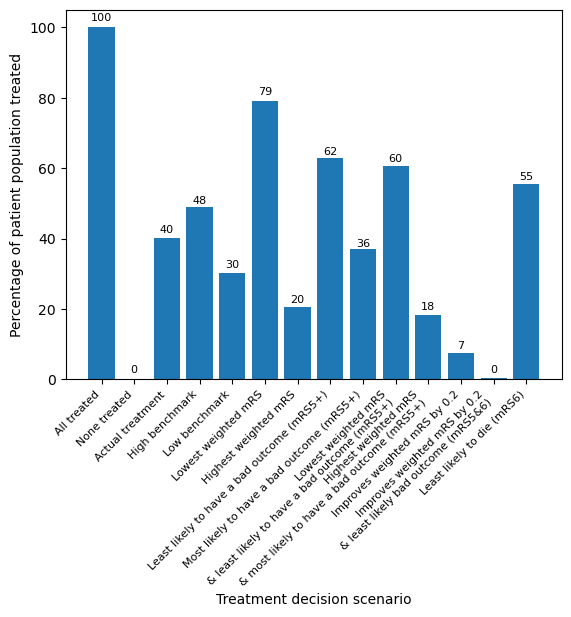

In [62]:
plot_bar(xticks, dict_dataframes["df_treated"][columns].mean()*100);

Define a function to create a violin plot to display the range of values for a population per treatment decision scenario.

In [63]:
def create_violin_plot(violin_data, xticks, y_label, ax=None, title=""):
    ax = ax or plt.gca()
    
    ax.violinplot(violin_data, showextrema=False, showmeans=True, widths=0.9)

    # customise the axes
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(columns) + 1))
    ax.set_xticklabels(xticks, rotation=45, fontsize=8, ha='right')

    ax.set_xlim(0.25, len(columns) + 0.75)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel('Treatment decision scenario', fontsize=12)
    ax.set_title(title, fontsize=12)

    return(ax)

Create a violin plot to display the range of weighted mRS scores for the whole population per treatment decision scenario.

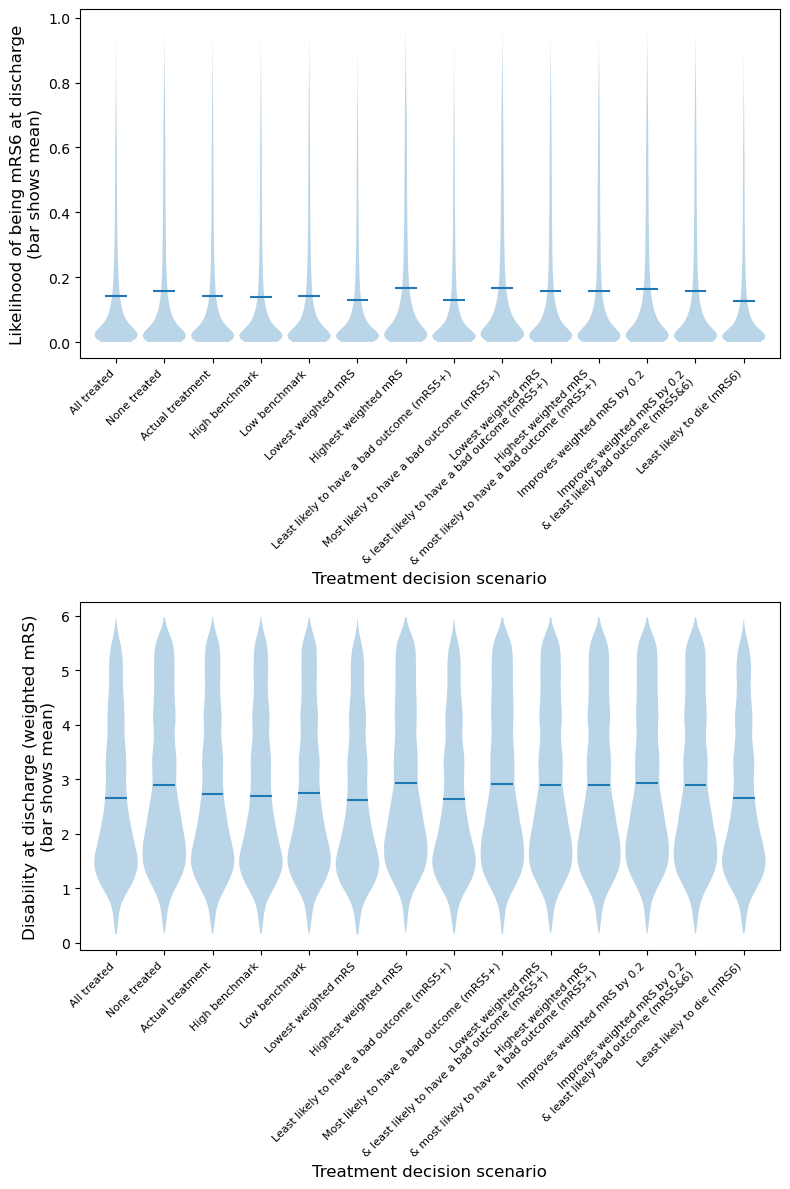

In [64]:
fig, axes = plt.subplots(2,1, figsize=(8,12))

create_violin_plot(df_prob_mrs6_per_scenario[columns], xticks, 
        'Likelihood of being mRS6 at discharge\n(bar shows '
        'mean)', ax=axes[0]);

create_violin_plot(df_weighted_mrs_per_scenario[columns], xticks, 
        'Disability at discharge (weighted mRS)\n(bar shows mean)', ax=axes[1]);

plt.tight_layout()

There are four other notebooks in this set that answer specific questions raised from these results:
* 211 Is it largely an effect of stroke severity?
* 212 Is there a bigger effect of treatment for patients with a worse predicted outcome without treatment?
* 213 Which type of patients have indifferent outcomes with treatment?
* 214 Are there patients that the high benchmarks are giving thrombolysis to, that they shouldn’t (causing harm)? - venn diagrams comparing agreement of who received treatment in different scenarios